 # Lesson Bayes
 Rev 2.1: 2-27-22

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy
from scipy import stats

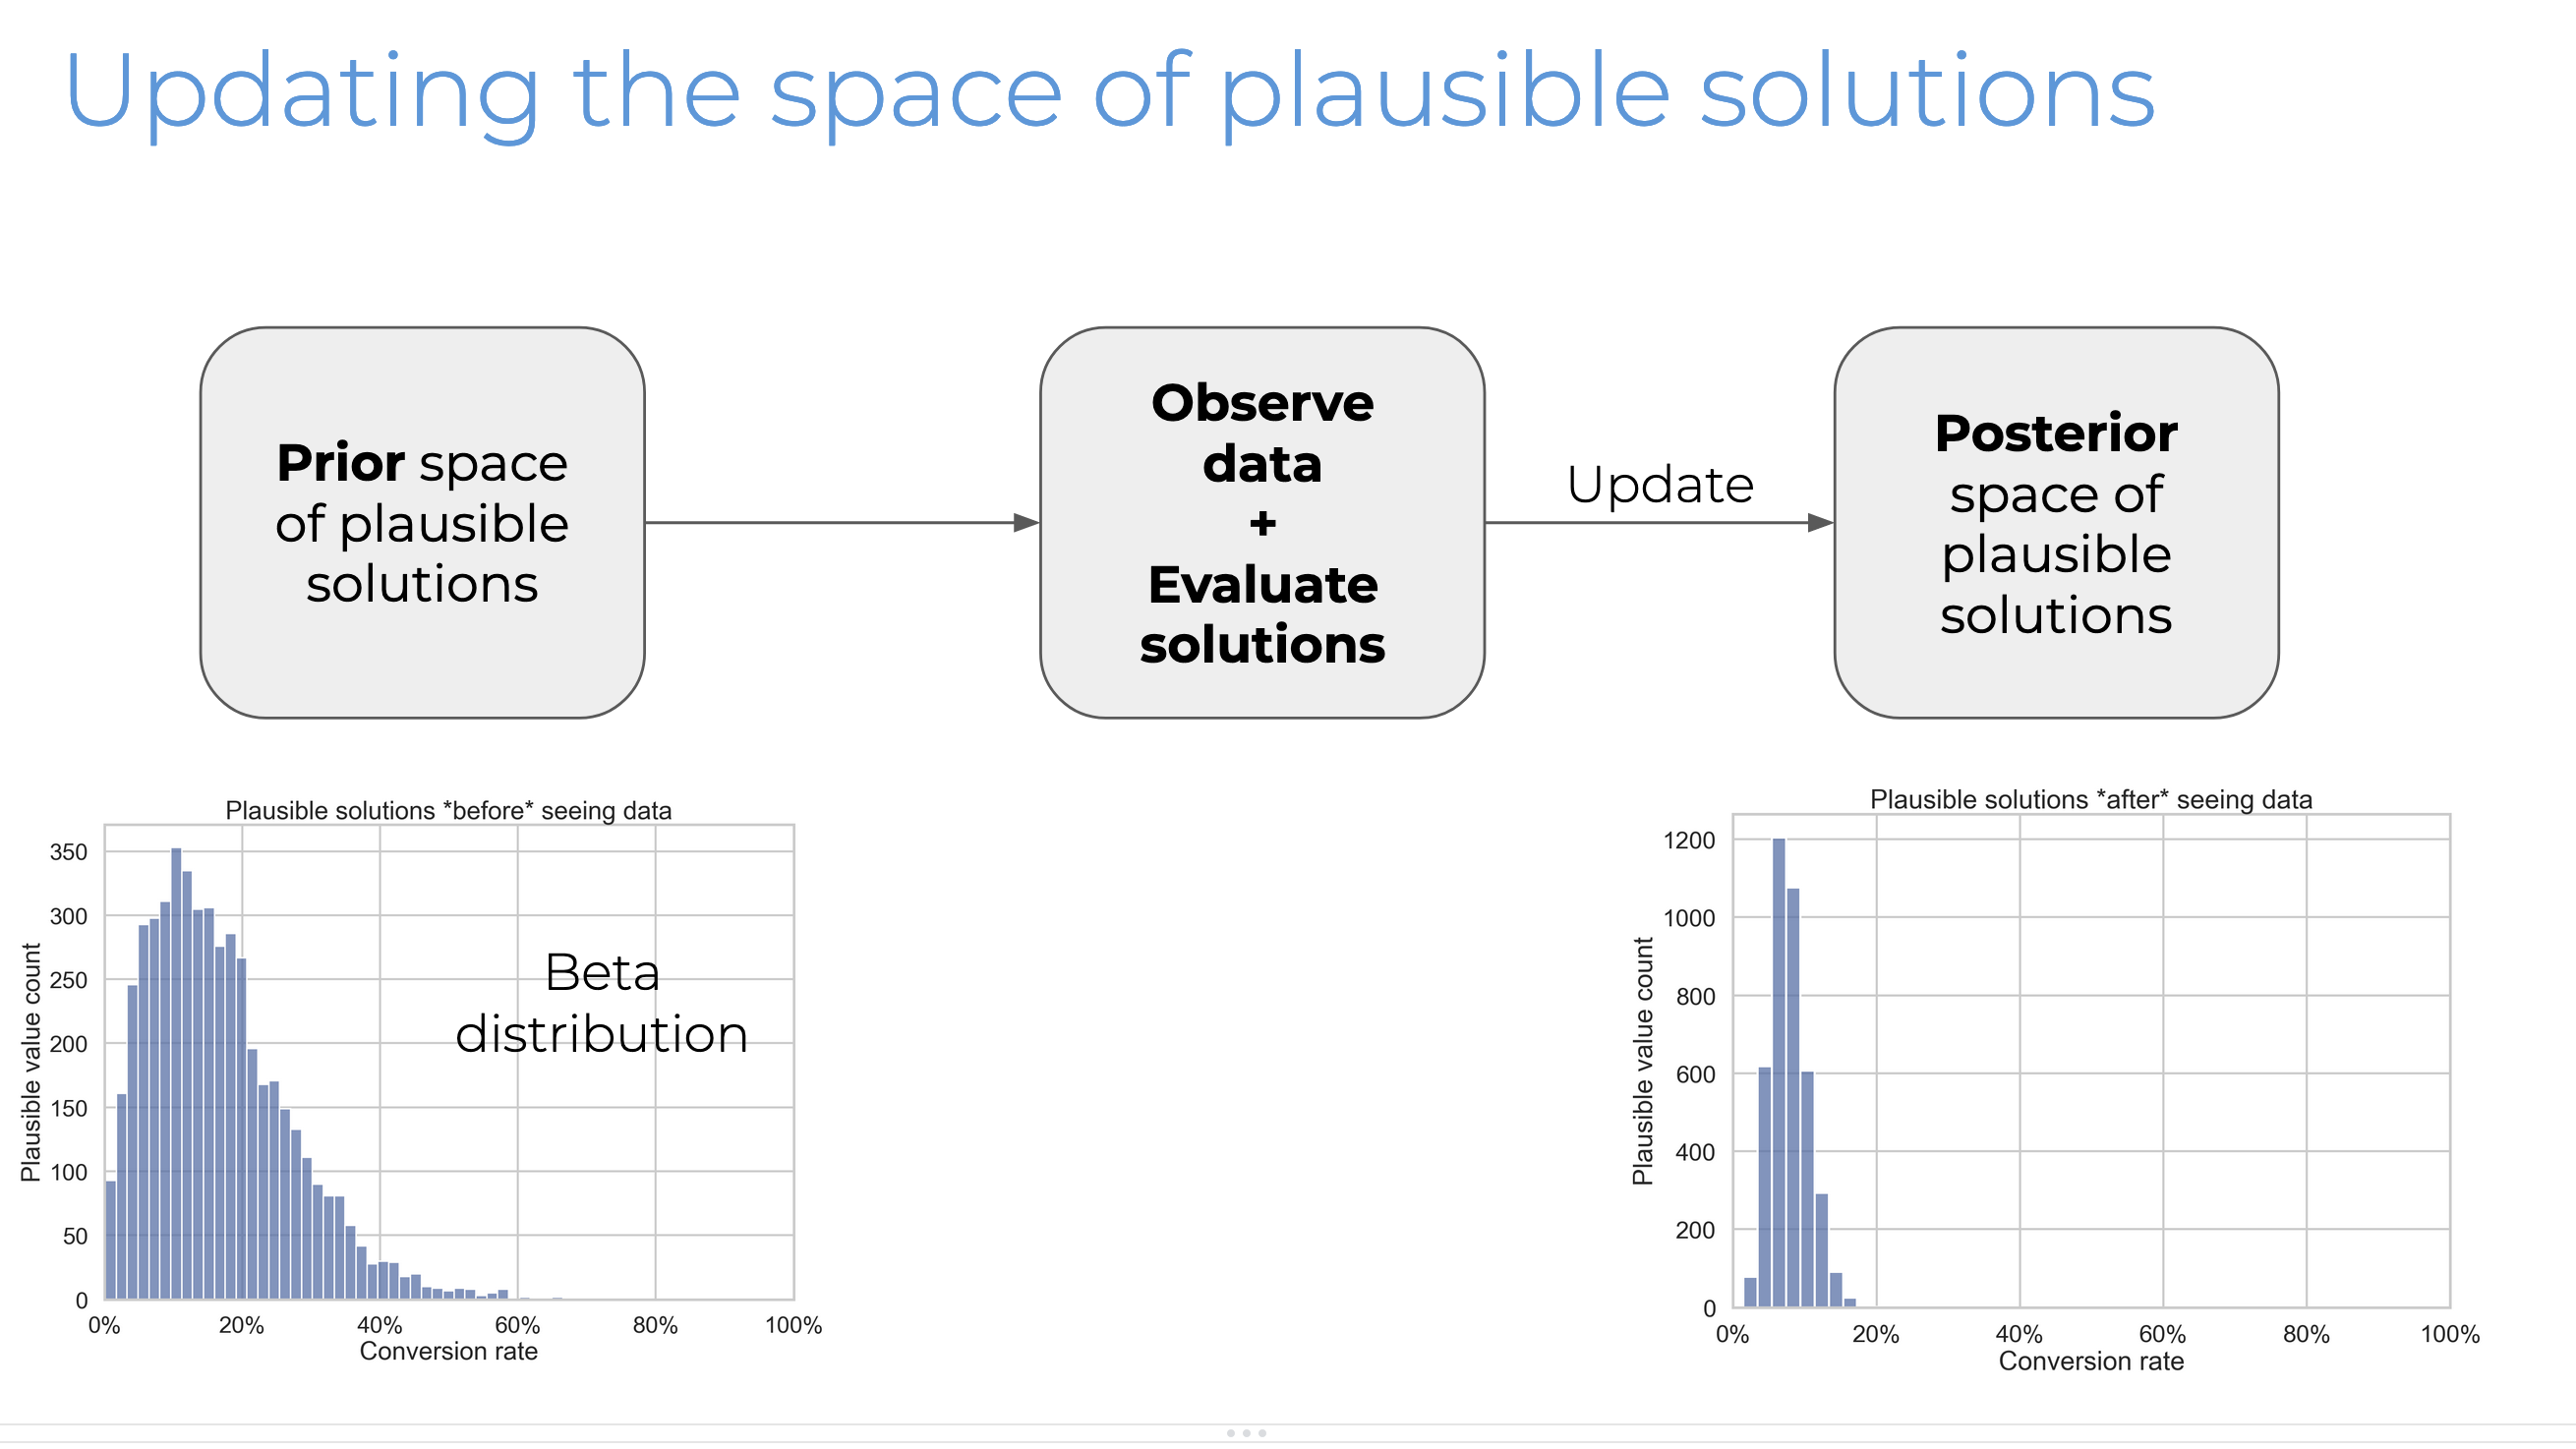

Remember this slide from the earlier lesson. In this lesson we're going to talk through each step

# The formula

$$ 
\underbrace{p(\boldsymbol{\theta} \mid \boldsymbol{Y})}_{\text{posterior}} = \frac{\overbrace{p(\boldsymbol{Y} \mid \boldsymbol{\theta})}^{\text{likelihood}}\; \overbrace{p(\boldsymbol{\theta})}^{\text{prior}}}{\underbrace{{p(\boldsymbol{Y})}}_{\text{marginal likelihood}}}
$$

Specifically we're going to go through each one of these terms and talk through the their theoretical meaning and their practical intuition

## Breaking down the A/B Test model

In [2]:
np.random.seed(3)
b = stats.bernoulli(p=.1)
conversions = b.rvs(100)

In [3]:
with pm.Model():
    
    # parameter we want to infer with prior
    conversion_rate = pm.Beta("conversion_rate", 2, 10)
    # likelihood of observing data given parameter
    likelihood = pm.Bernoulli("likelihood", 
                                p=conversion_rate, 
                                observed=conversions)
    
    # Posterior
    idata = pm.sample()
    
    # Prior Predictive
    idata.extend(pm.sample_prior_predictive())
    
    # Posterior Predictive
    idata.extend(pm.sample_posterior_predictive(idata))
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


## What we'll cover in this lesson

* The formal definition of Bayes Theorem
  * Prior
  * Likelihood
  * Posterior
* The predictive distributions
  * Prior Predictive
  * Posterior Predictive

# Priors
Expressing plausibility before seeing data

$$ 
p(\boldsymbol{\theta} \mid \boldsymbol{Y}) = \frac{p(\boldsymbol{Y} \mid \boldsymbol{\theta})\; \overbrace{p(\boldsymbol{\theta})}^{\text{prior}}}{{p(\boldsymbol{Y})}}
$$

## A/B Testing: What do we know before we see the data?
Before running the experiment what do we believe the conversion ratio could be?

* Any value between 0% and 100% equally?
* Probably 20% based on past experience?
* Definitely not above 40%?

## Priors distributions can let us express our expert knowledge
Each of these distributions showcase a different belief

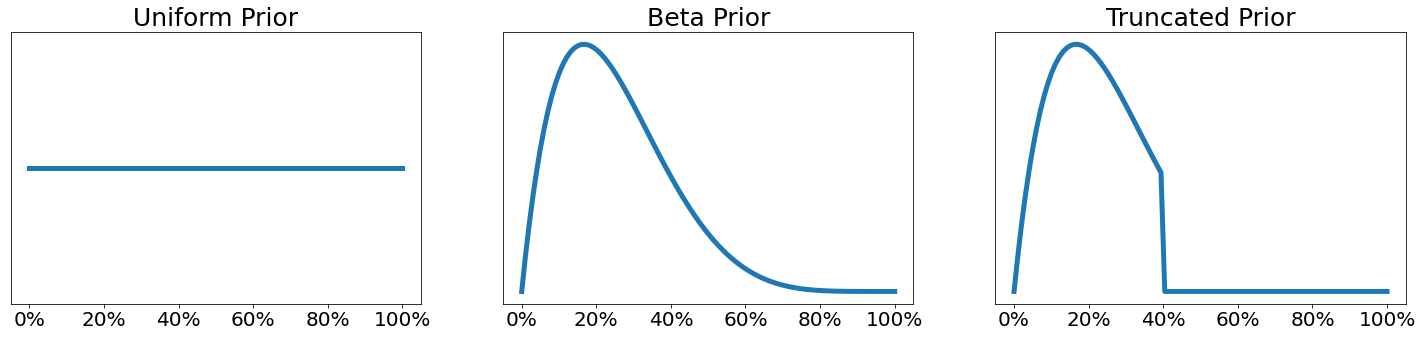

In [4]:
import matplotlib.ticker as mtick

def priors(labels):
    fig, axes = plt.subplots(1, 3, figsize=(25,5))

    x = np.linspace(0,1,100)

    unif = stats.uniform(0,1)
    axes[0].plot(x, unif.pdf(x), lw=5)
    axes[0].set_title(labels[0], fontsize=25)

    beta = stats.beta(2,6)
    axes[1].plot(x, beta.pdf(x), lw=5)
    axes[1].set_title(labels[1], fontsize=25)


    truncated = stats.beta(4,12)
    pdf = beta.pdf(x)
    pdf[x>.4] = 0
    axes[2].plot(x, pdf, lw=5)
    axes[2].set_title(labels[2], fontsize=25)

    for ax in axes:
        ax.set_yticks([])
        ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        ax.tick_params(axis="x", labelsize=20)
    return 

labels = ["Uniform Prior", "Beta Prior", "Truncated Prior"]
priors(labels)

Writing priors in PyMC
* Show example from alex's lesson

## The rationale behind the prior is what's important

You may be now thinking "Well how do I know the right/best/correct prior?" The truth is you won't.

There's a famous quote stating "All models are wrong, some are useful"

When selecting priors the task is not to pick the right prior *independent of any other factor*, but one that you can justify in context with
* the rest of the model
* how your model will be used in reality
* the experience of domain experts

## Priors are a form of regularization


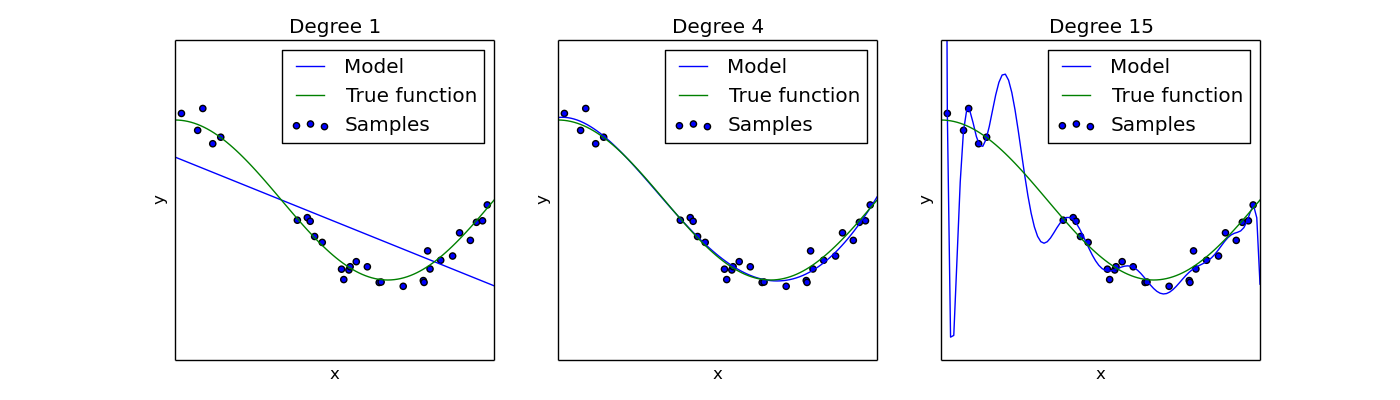
**Source**: scikit-learn documentation

Another benefit of priors is they can be utilized to focus the models on reasonable possibilities and not far flung parameters that happen optimize a metric.

In other words we can use priors to
* Highlight reasonable possible parameters
* Penalize unreasonable possible parameters

For example in the case below if we were using a Bayesian model to estimate the degree of fit of a polynomial, we could choose to put a prior with high beliefs on polynomial degree 2-6, but lesser belief on 0, 1 and greater than 8

## Section Recap
* Priors distributions express the plausibility of parameters prior to seeing data
* When choosing a prior focus on the rationale behind the prior, not picking the "right" prior


# Likelihoods
The plausibility of the data given a parameter

$$ 
p(\boldsymbol{\theta} \mid \boldsymbol{Y}) = \frac{\overbrace{p(\boldsymbol{Y} \mid \boldsymbol{\theta})}^{\text{Likelihood}}\; p(\boldsymbol{\theta})}{{p(\boldsymbol{Y})}}
$$

## The connection between data space and parameter space



In [ ]:
# likelihood of observing data given parameter
likelihood = pm.Bernoulli("likelihood", 
                            p=conversion_rate, 
                            observed=conversions)

## What is the likelihood (intuitively)?
For our A/B test example let's say we on variant B we see *100* visits and *85* of them convert.

What is the plausibility that the true conversion rate, p(conversion) is:
* 1%
* 100%
* 80%
* 95%

Pause the video here and rank these from most to least plausible before continuing on

## Intuitively ranking `p(conversion)` values?

1. 80%
2. 95%
3. 1%
4. 100%



Out of 100 visits, 85 converted. That brings us to an *empirical* conversion rate of 85%, but as Bayesians we also want to know the plausibility of all other conversion rates.

Intuitively we know a 100% conversion rate impossible. If even 1 person didn't convert the true conversion rate can't be 100%.

1% is highly implausible but *it is still possible*. It may be that in our sample of 100 we were lucky to get 85, but it's not likely.

Intuition may not be enough to differentiate  80% and 95%, let's show how to calculate likelihood

## Manually Calculating Likelihood
We use the tool of PMFs and PDFs to measure the plausibility of a parameter given data.

For the A/B test we use a binomial likelihood with our observed data, and plug in our parameter to get a number.

## Review note
Manual implementation from Thomas's is wrong because it doesn't include the categorical factor. 

Because its not this simple I think we should just leave it out, I dont want to explain what factorial is, why we need it, and the notation for it. I think its better just to leave it out and stick to scipy stats and intuition

https://docs.google.com/presentation/d/1cBkNsV0OYpOayvNmOM14NJgRHVBO7g_-7HToirvO8vw/edit#slide=id.g10400ea9c94_0_413
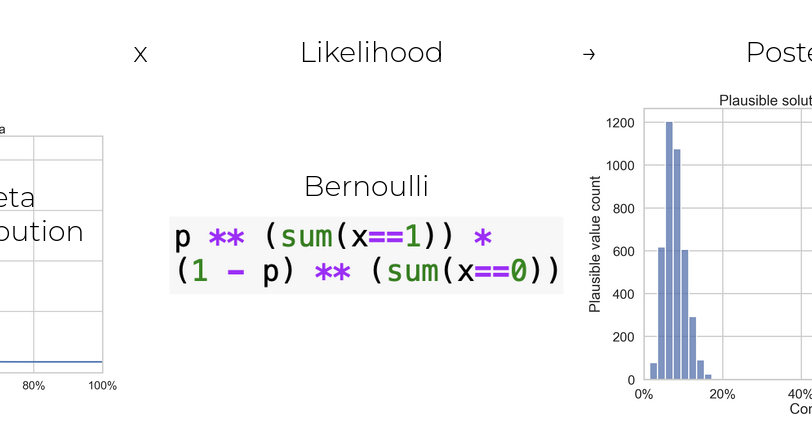

In [5]:
observed = np.array([0, 1,1])

p=.3
stats.binom(p=p, n=3).pmf(observed.sum())

0.18899999999999992

#### From slide gets wrong answer

In [6]:
x=observed
p**sum(x==1) * (1-p)**sum(x==0)

0.063

#### How to get proper answer

In [7]:
(3*2*1)/(2*1)*p**sum(x==1) * (1-p)**sum(x==0)

0.189

## Calculating Likelihood is just calculated PDF

In [8]:
num_conversions, num_visitors = 85, 100
possible_true_conversion_rate = .80

binom = stats.binom(p=possible_true_conversion_rate, n=num_visitors)
binom.pmf(num_conversions)

0.0480617937007464

The calculation for a likelihood is just calculating the PDF! We plug in a possible conversion value, and the data and we get a value back.

Remember though that the PMF, or PDF, values only mean something relative to each other. We need to compare our likelihood at 80% with the one at 95%



## Calculating Multiple Likelihoods for multiple possible conversion percentages


In [9]:
multiple_possible_true_conversion_rates = [.01, .8, .95, 1]

binom = stats.binom(p=multiple_possible_true_conversion_rates, n=num_visitors)
binom.pmf(num_conversions)

array([2.17885869e-153, 4.80617937e-002, 9.88001628e-005, 0.00000000e+000])

The results match our intuition. 100% conversion is impossible, given a value of zero, 1% is highly unlikely, and comparing 80% and 95%, 80% is more likely

This is great, now we have a way of quantifying the plausibility of the observed data given a parameter.

Let's use a handy trick from SciPY where we can plug in all four parameter values and calculate the likelihood in one go.

## What is the most plausible line?


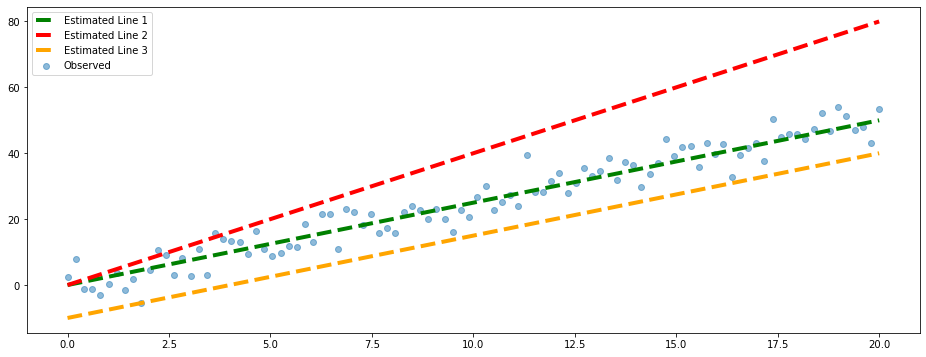

In [10]:
RANDOM_SEED = 8265
np.random.seed(RANDOM_SEED)
x = np.linspace(-0, 20, 100)
slope_true = 2.5

y_obs = x*slope_true + stats.norm(0,4).rvs(100)

fig, ax = plt.subplots(figsize=(16,6))
ax.scatter(x, y_obs, alpha=.5, label="Observed")

lw=4
ax.plot(x, slope_true*x, c="g", lw=lw, ls="--", label="Estimated Line 1" )
ax.plot(x, 4*x, c="r", lw=lw, ls="--", label="Estimated Line 2")
ax.plot(x, (slope_true*x) -10, c="orange", lw=lw, ls="--", label="Estimated Line 3")

plt.legend();

Linear regressions have at least two parameters, but all the same concepts apply

Plausibility can exist in more than two dimensions. See an example below for a linear regression.

Which line seems the most plausible to you?

Later on in this course we'll show how to use Bayesian tools to answer this questions quickly and easily.

## PyMC will automatically calculate likelihood
In practice you'll never calculate likelihood manually, PyMC will do it for now

In [ ]:
with pm.Model():
    
    # parameter we want to infer with prior
    conversion_rate = pm.Beta("conversion_rate", 2, 10)
    
    
    # likelihood of observing data given parameter
    likelihood = pm.Bernoulli("likelihood", 
                                p=conversion_rate, 
                                observed=conversions)

Now that you know the fundamental math and have an intuition behind likelihood I'm happy to tell you, PyMC will do all the work for you.

All you need to do is specify the likelihood distribution is add `observed` as an argument.

All the above will get you prepped for the next, and most important topic, getting the posterior

## Section Recap
* Likelihood measures the plausibility of parameters given data
    * It answers the question "Given this observed data what parameters are the most likely to have produced it?"
* Likelihood is measured by the PDF or PMF the data given a fully specified distribution

# Posterior
The coveted distribution that enables *inference*

$$ 
\overbrace{p(\boldsymbol{\theta} \mid \boldsymbol{Y})}^{\text{Posterior}} = \frac{p(\boldsymbol{Y} \mid \boldsymbol{\theta})\; p(\boldsymbol{\theta})}{{p(\boldsymbol{Y})}}
$$

## The fundamental question
If we observe something, what can we infer about the world in general?

Or as statistician would say 

If we have 
1. *observed samples* from the world
2. a *model* of how the world works
3. a *prior* belief

What is our updated belief after seeing our observations? 

It's the posterior distribution

## Getting the posterior for our A/B Test 
Remember, to get a posterior we need
* Prior(s)
* Data
* Likelihood

Let's review what we've seen thus far

In [12]:
# Replace with a data load
np.random.seed(3)
b = stats.bernoulli(p=.1)
conversions = b.rvs(100)


In [13]:
with pm.Model() as ab_test_model:
    
    # parameter we want to infer with prior
    conversion_rate = pm.Beta("conversion_rate", 2, 10)
    # likelihood of observing data given parameter
    likelihood = pm.Bernoulli("likelihood", 
                                p=conversion_rate, 
                                # This is the important keyword argument
                                observed=conversions)

# The magic inference button

In [14]:
with ab_test_model:
    # Posterior
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


In [15]:
idata.posterior

<xarray.Dataset>
Dimensions:          (chain: 4, draw: 1000)
Coordinates:
  * chain            (chain) int64 0 1 2 3
  * draw             (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
Data variables:
    conversion_rate  (chain, draw) float64 0.07435 0.06547 ... 0.04898 0.04518
Attributes:
    created_at:                 2022-04-24T21:11:16.586767
    arviz_version:              0.11.4
    inference_library:          pymc
    inference_library_version:  4.0.0b2
    sampling_time:              15.422137975692749
    tuning_steps:               1000

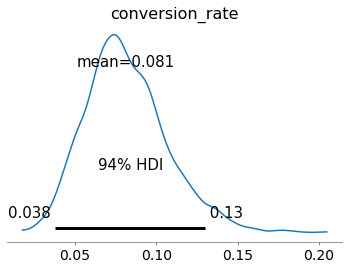

In [16]:
az.plot_posterior(idata.posterior);

With that PyMC combines the prior distribution, likelihood distribution, and data togetrher

# Change the prior and data and see the effects
Download this notebook and change the prior and data and see what happens. Try using
* A wide prior
* More observations
* Less observations
* Different level of conversions

#  What's the magic inference button doing 

It's using Markov Chain Monte to estimate the posterior which

* Works well on many models relatively automatically
* Is efficient and returns results relatively quickly
* Comes with a good set of diagnostics to guide you


You've seen MCMC many times now, and now you have sense of what its doing. By usising distributions that define PMF and PDF, calculating likelihoods, and testing specific parameters in a specialized way its able to help us perform inference.

# Section Recap
* Posterior distributions 
    * allow us to perform *inference* the goal of statistics
    * incorporate the data, the model, and our priors
* Bayesian updating is the process of combining prior, likelihood, data
* Posterior estimation is not always "easy or straightforward"
    * PPLs typically estimate the posterior with a sampling technique called MCMC 

## MCMC

What is going on?

Insert model T vs F1 algorithm

Let's estimate conversion without a PPL

In [ ]:

def post(θ, observed, α=1, β=1):
    if 0 <= θ <= 1:
        
        # Prior
        prior = stats.beta(α, β).pdf(θ)
        
        # Likellihood
        like  = stats.bernoulli(θ).pmf(observed).prod()
        
        # Multiplication
        prob = like * prior
    else:
        
        # If out of bounds 
        prob = -np.inf
    return prob

1. Get the posterior value of where you are
2. Randomly select another parameter
3. Calculate posterior value at new parameter value
4. Calculate ratio

5. Draw a random value from a uniform distribution
6. If value from

# The predictive distributions

Rough notes



## Parameter Space
So far with prior, and posterior we've been in parameter space, estimating conversion rate, but if we want to know how many people we believe will convert, that is what we will observe

## Prior Predictive
This shows us before we incorporate data. Let's use PyMC to generate this its quite easy its only one line. Note we don't even need to sample posterior, remember this is the distribution *before* we incorporate any data

## Posterior Predictive
This shows us our beliefs after we've performed inference

## Why Prior predictive is useful
* Lets us understand our priors
* Test our model is specified correctly

## Why is posterior predictive useful
* Sometimes were not interseted in the parameters at all, but only what we believe will happen. You'll see that in the next lesson
* Other times we need to make a decision. Posterior predictive gives us not only the most likely future, but every single possible future weighted with the probability it will happen

## Generative modeling
These tools are possible because Bayesian models are generative, meaning they can generate outcomes. This is an incredible benefit over discriminative models, which can only point to pick between set outcomes, but not generate all possible outcomes

## Section Recap
Generative distributions are
* Super useful
* Very easy to obtain using PyMC
* A huge capability not available with many other stats methods

# Insert Common Distributions here

# Bayes Rule Summary
* The three terms we care about in Bayes Rule
  * And the one we don't
* The different types of priors
  * Informative 
  * Uninformative
* How to calculate likelihood given data
* How to calculate a simple posterior